# Activity

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [163]:
netflix_data = pd.read_csv('data/NFLX.csv', sep=',')

netflix_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


Let's find out more information about the dataset.

In [164]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4581 non-null   object 
 1   Open       4581 non-null   float64
 2   High       4581 non-null   float64
 3   Low        4581 non-null   float64
 4   Close      4581 non-null   float64
 5   Adj Close  4581 non-null   float64
 6   Volume     4581 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 250.6+ KB


As we can see there are no missing values in the dataset. The dataset has 7 columns.
Attributes: 
- Date: Date of the observation
- Open: Opening price of the stock
- High: Highest price of the stock
- Low: Lowest price of the stock
- Close: Closing price of the stock
- Adj Close: Adjusted closing price of the stock
- Volume: Volume of the stock traded

All of the attributes are numerical, only the date is a object.

In [165]:
netflix_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4.581000e+03
mean,78.031471,79.285690,76.736079,78.072056,78.072056,1.760516e+07
std,118.372084,120.276839,116.376768,118.435303,118.435303,1.971130e+07
min,0.377857,0.410714,0.346429,0.372857,0.372857,2.856000e+05
25%,3.778571,3.857143,3.685714,3.784286,3.784286,6.908900e+06
50%,15.392858,15.671429,14.970000,15.324286,15.324286,1.155350e+07
75%,97.830002,99.529999,96.760002,97.889999,97.889999,2.113440e+07
max,567.979980,575.369995,520.960022,548.729980,548.729980,3.234140e+08


We can see that the data is from 2002 to 2022 year.

In [166]:
netflix_data.nunique()

Date         4581
Open         4058
High         4036
Low          4021
Close        4120
Adj Close    4120
Volume       4452
dtype: int64

In [167]:
netflix_data.shape[0] - netflix_data.drop_duplicates().shape[0]

0

The are no duplicate rows in the dataset.

Let's convert Date object to the same date format.

In [168]:
netflix_data['Date'] = pd.to_datetime(netflix_data['Date'])
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4581 non-null   datetime64[ns]
 1   Open       4581 non-null   float64       
 2   High       4581 non-null   float64       
 3   Low        4581 non-null   float64       
 4   Close      4581 non-null   float64       
 5   Adj Close  4581 non-null   float64       
 6   Volume     4581 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 250.6 KB


#### Data distribution

array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'Adj Close'}>],
       [<Axes: title={'center': 'Volume'}>, <Axes: >, <Axes: >]],
      dtype=object)

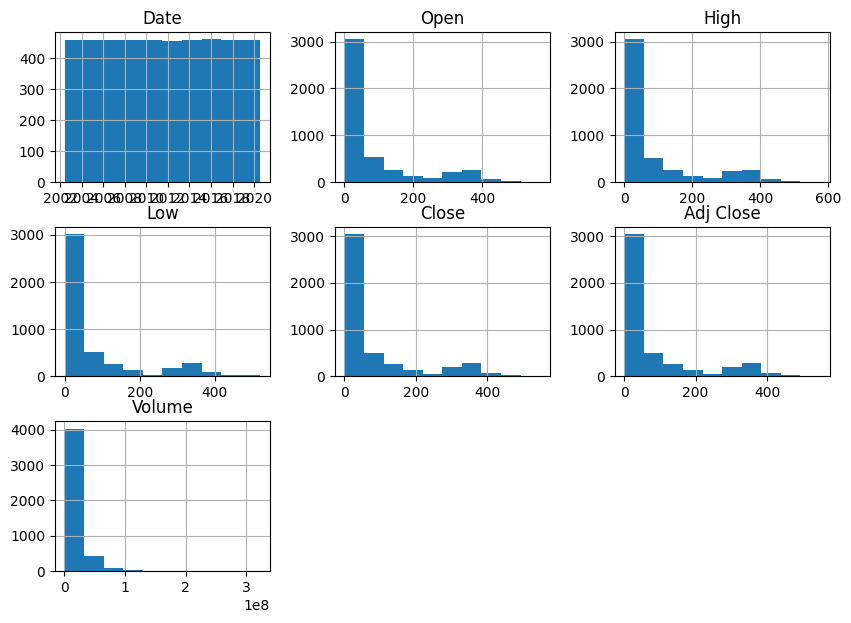

In [169]:
netflix_data.hist(figsize=(10,7))

#### Correlation matrix


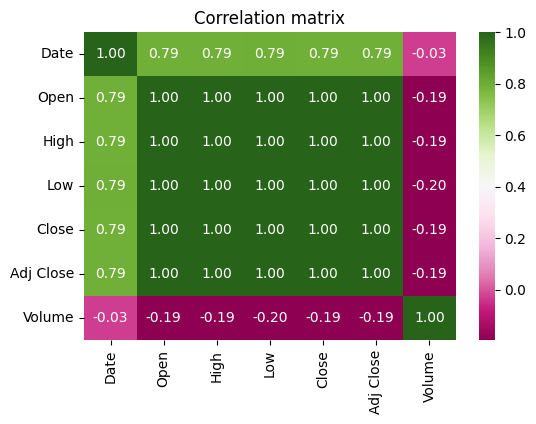

In [170]:
netflix_data_corr = netflix_data.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(netflix_data_corr, fmt='.2f', annot=True, cmap='PiYG')
plt.title('Correlation matrix')
plt.show()

Volume has the least correlation with other attributes but in our opinion it still matter, becase the correlation between Volume and stock prices is 0.19 in average, and it is not so low. There are also correlation 1 between Open, High, Low, Close and Adj Close prices. It is obvious that they are highly correlated, because they are the same stock prices, but in different time of the day.

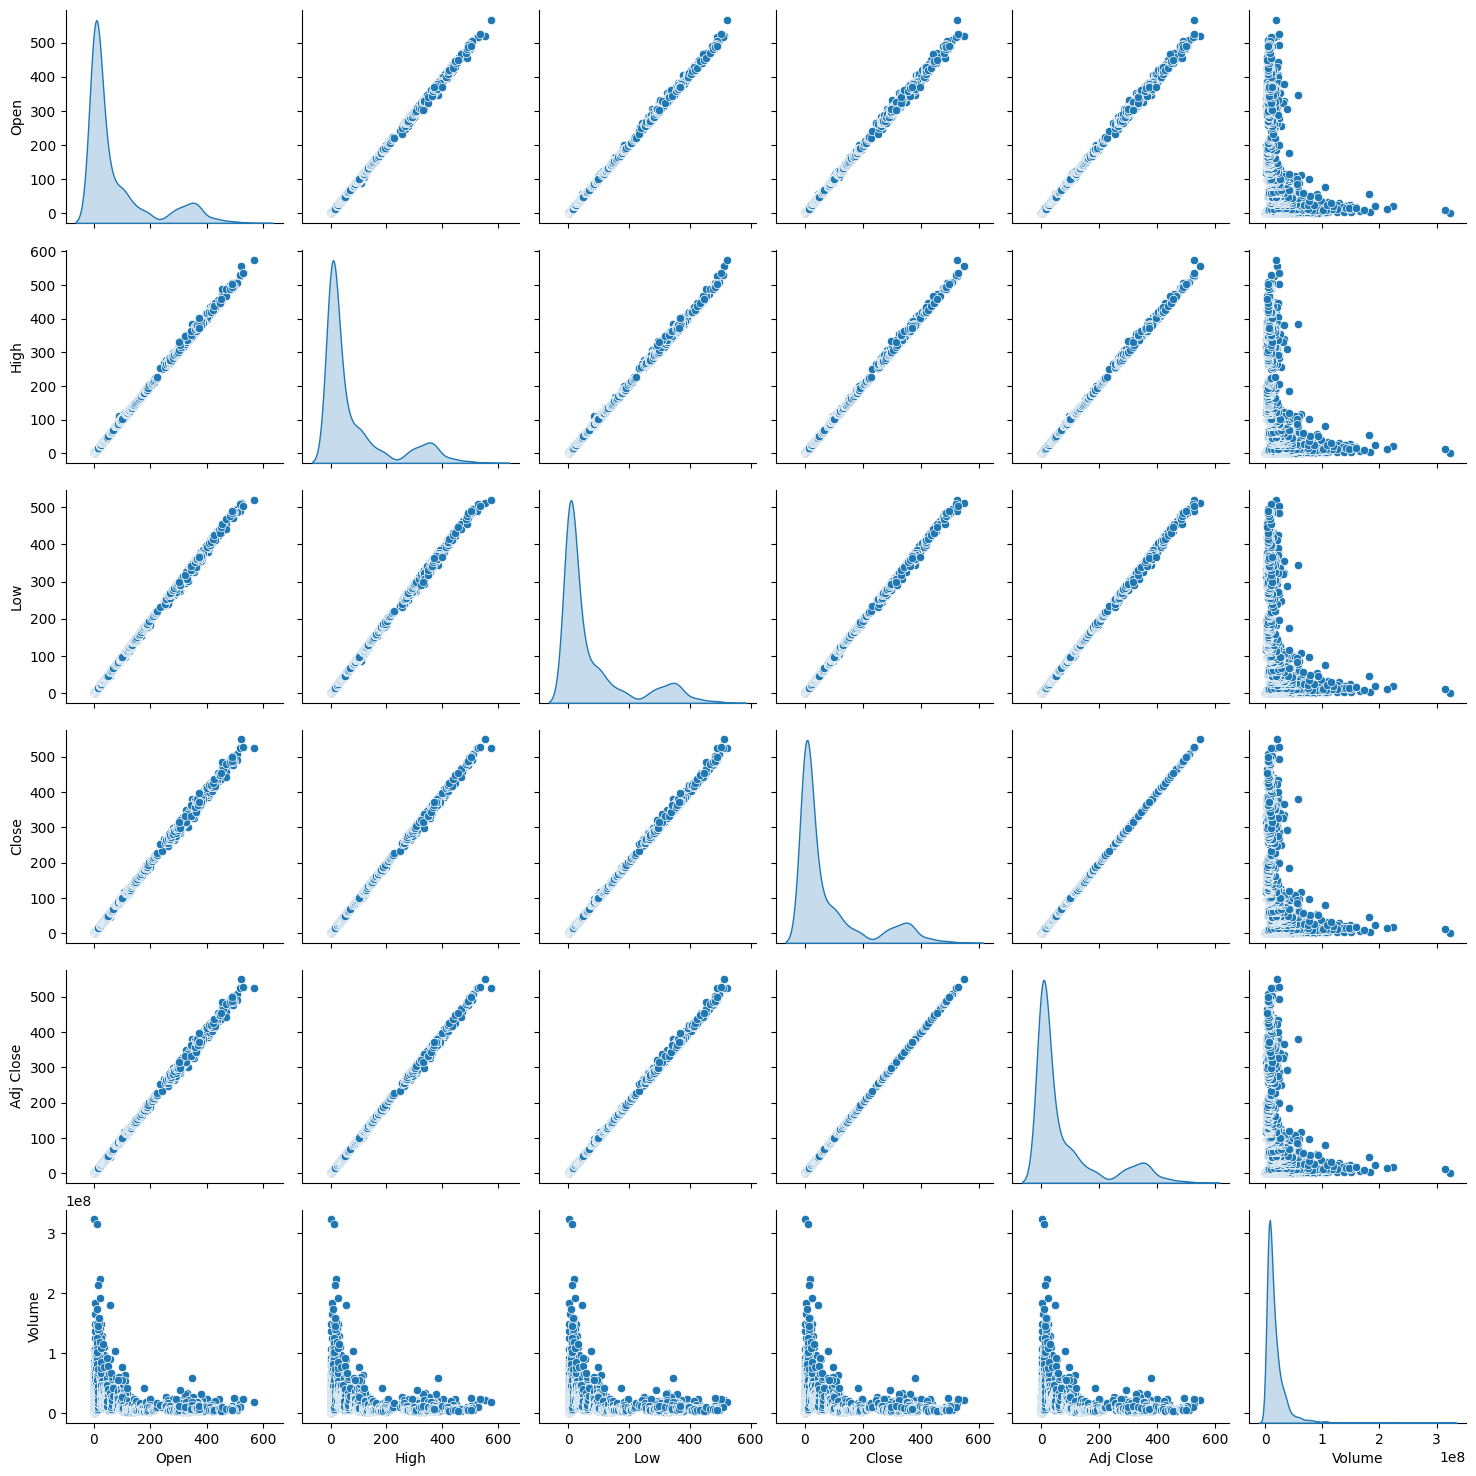

In [171]:
sns.pairplot(netflix_data, diag_kind='kde')

popis laaalalal

### Distribution of the stock prices by years

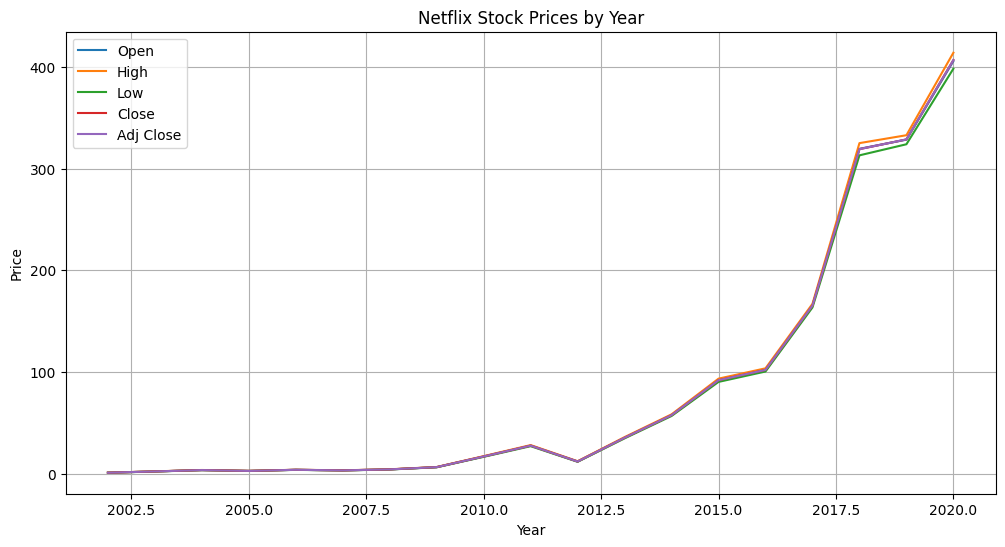

In [172]:
netflix_data['Year'] = netflix_data['Date'].dt.year

yearly_data = netflix_data.groupby('Year').mean()
plt.figure(figsize=(12, 6))
for column in ["Open", "High", "Low", "Close", "Adj Close"]:
    plt.plot(yearly_data.index, yearly_data[column], label=column)

plt.title('Netflix Stock Prices by Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


As we can see the stock prices are increasing over the years. It started to significantly increase after 2010 year. The stock prices are pretty simmilar between open, high, low and close prices.

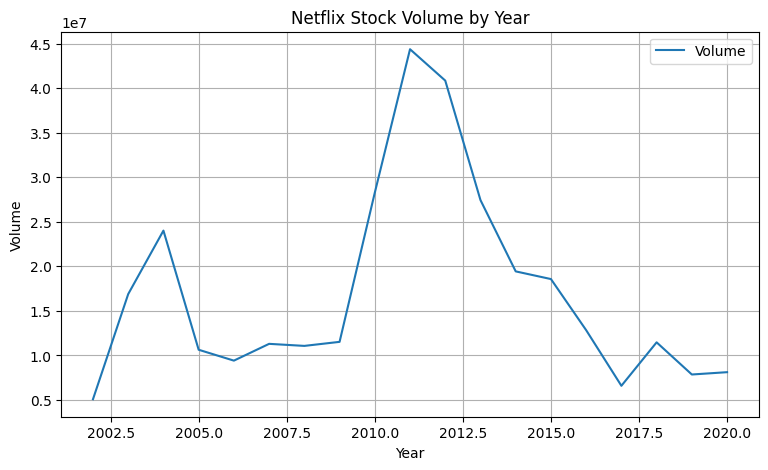

In [173]:
plt.figure(figsize=(9, 5))
for column in ["Volume"]:
    plt.plot(yearly_data.index, yearly_data[column], label=column)

plt.title('Netflix Stock Volume by Year')
plt.xlabel('Year')
plt.ylabel('Volume')
plt.legend()
plt.grid()
plt.show()

netflix_data = netflix_data.drop(columns=['Year'])

From the plot above we can see that the highest volume was traded between year 2010 and 2012. After that the volume of the stock traded is decreasing.

## Data preprocessing

In [174]:
train_data, test_data = train_test_split(netflix_data, test_size=0.25)

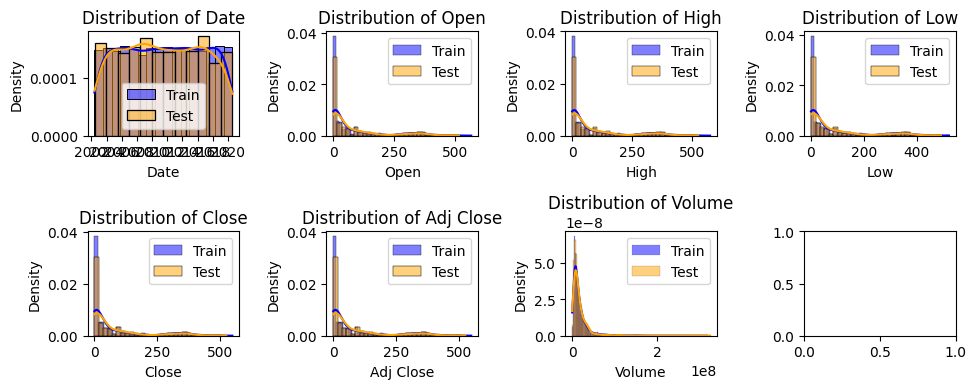

In [175]:
num_columns = 4
num_rows = 2
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, num_rows * 2))
axes = axes.flatten()

for idx, column in enumerate(train_data.columns):
    sns.histplot(train_data[column], color='blue', label='Train', kde=True, stat="density", ax=axes[idx])
    sns.histplot(test_data[column], color='orange', label='Test', kde=True, stat="density", ax=axes[idx])
    axes[idx].set_title(f'Distribution of {column}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

As we can see the distribution between train and test data is pretty simmilar, that why we can say that the data is well splitted.

## Encoding
All of the attrivutes are numerical, only the date is a object. We will encode the date to year, month and day so it will be numerical.

In [176]:
train_data['year'] = train_data['Date'].dt.year
train_data['month'] = train_data['Date'].dt.month
train_data['day'] = train_data['Date'].dt.day
train_data = train_data.drop(columns=['Date'])

### Outliers

<Axes: >

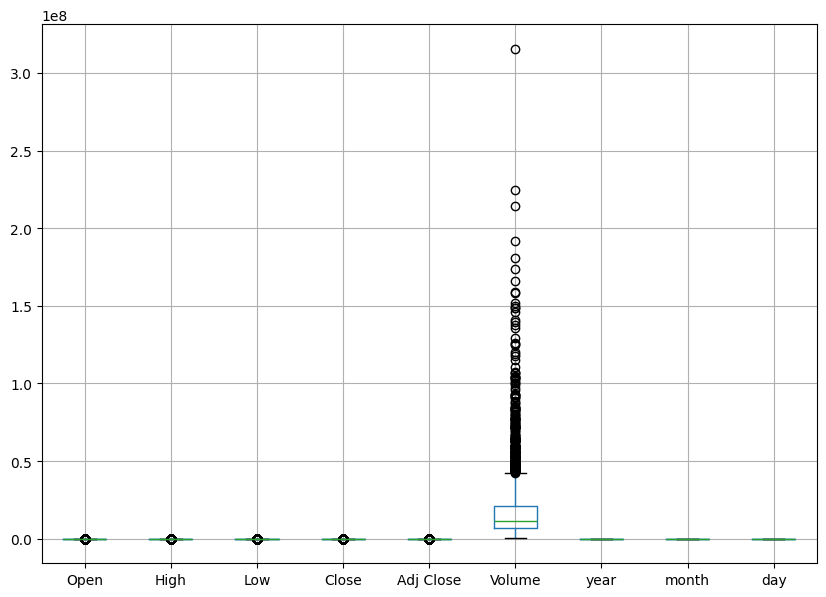

In [177]:
train_data.boxplot(figsize=(10, 7))

Let's count the number of outliers in the dataset. We will use the IQR method to detect the outliers.

In [178]:
def transform_outliers(column):
      Q1 = column.quantile(0.25)
      Q3 = column.quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR

      outliers = column[(column < lower_bound) | (column > upper_bound)]
      print('Identified outliers: ', outliers.count())
      cleaned_column = column.clip(lower=lower_bound, upper=upper_bound)
      return cleaned_column

for column in train_data.columns:
      train_data[column] = transform_outliers(train_data[column])

Identified outliers:  488
Identified outliers:  489
Identified outliers:  486
Identified outliers:  488
Identified outliers:  488
Identified outliers:  236
Identified outliers:  0
Identified outliers:  0
Identified outliers:  0


We fixed outliers with clip strategy.

<Axes: >

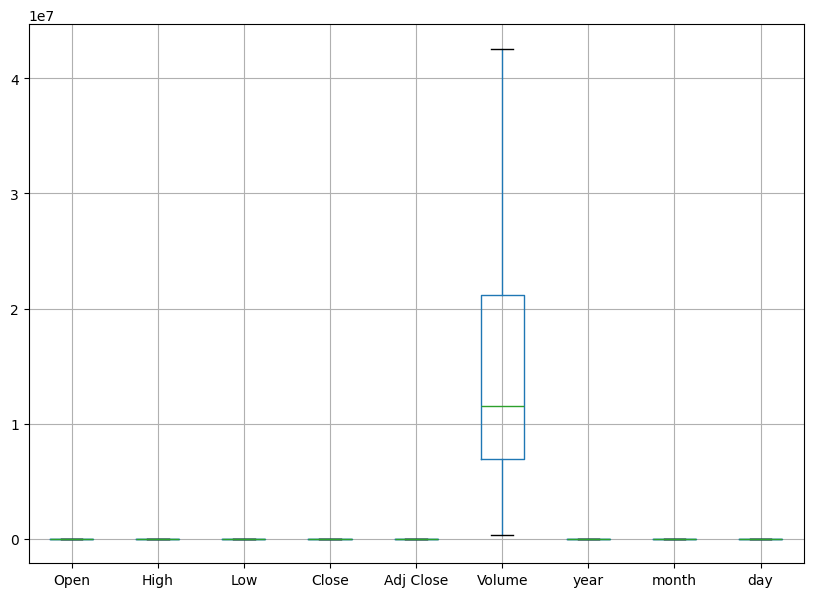

In [179]:
train_data.boxplot(figsize=(10, 7))

In the plot above we can see tha there are no outliers in the dataset.

### Data transformers

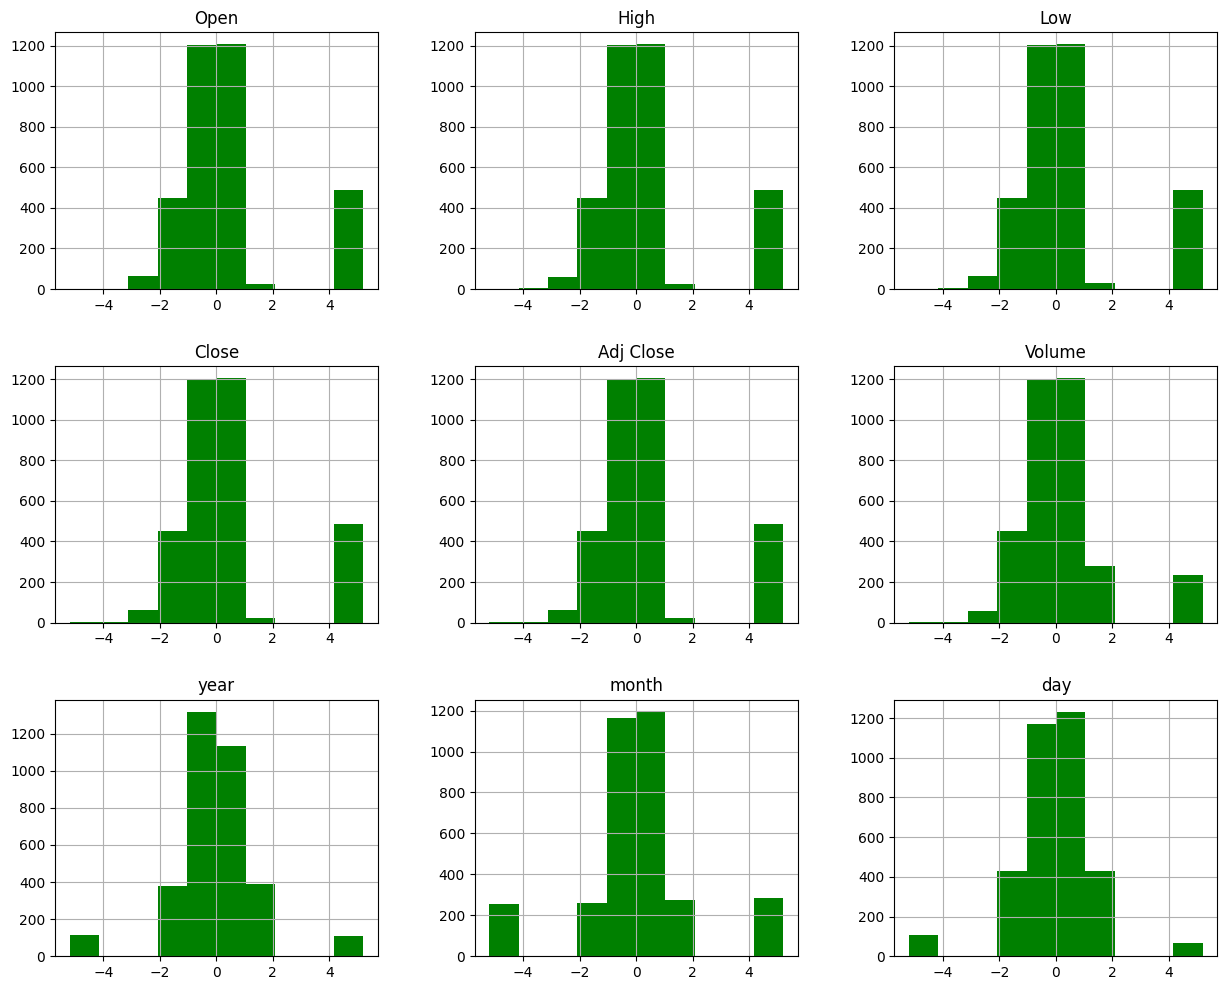

In [180]:
quantile_transformer = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
quantile_transformer.fit(train_data)


data_transformed = quantile_transformer.transform(train_data)
train_data = pd.DataFrame(data_transformed, columns=train_data.columns)

train_data.hist(figsize=(15, 12), color='green')
plt.show()

### Data scaler 

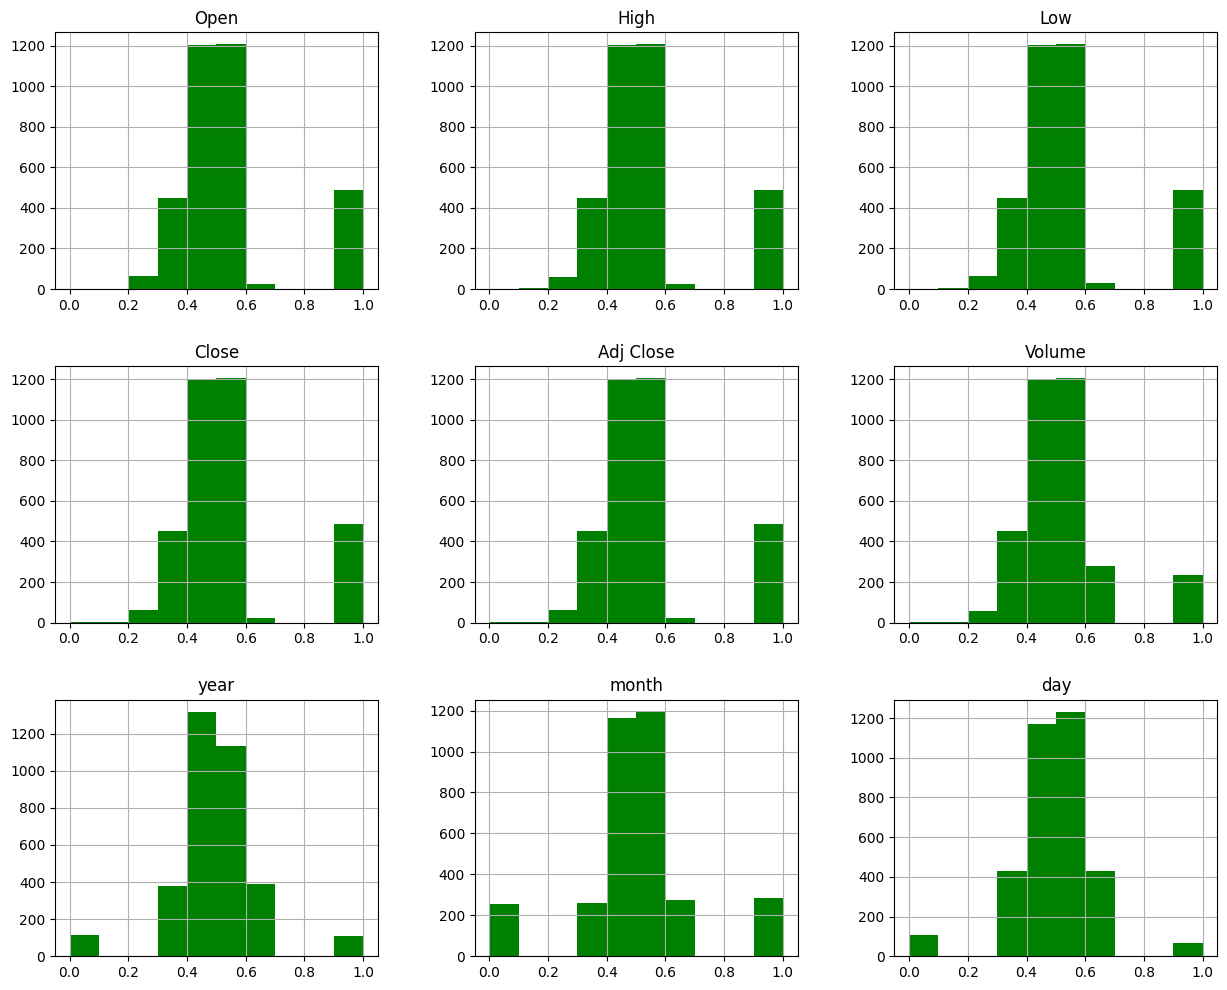

In [181]:
scaler = MinMaxScaler()
scaler.fit(train_data)

train_data_scaled = scaler.transform(train_data)

train_data  = pd.DataFrame(train_data_scaled, columns=train_data.columns, index=train_data.index)
train_data.hist(figsize=(15, 12), color='green')
plt.show()

### Autoregressive Moving Average (ARMA) Model 
The term “autoregressive” in ARMA means that the model uses past values to predict future ones. Specifically, predicted values are a weighted linear combination of past values. This type of regression method is similar to linear regression, with the difference being that the feature inputs here are historical values. 

In [196]:
train_data, test_data = train_test_split(netflix_data["Close"], test_size=0.25, shuffle=False)


ADF Statistic: -26.115188939576388
p-value: 0.0


d:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 3435
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -21275.555
Date:                            Fri, 06 Dec 2024   AIC                          42561.111
Time:                                    11:18:17   BIC                          42591.800
Sample:                                         0   HQIC                         42572.076
                                           - 3435                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0013      0.017     -0.075      0.940      -0.035       0.032
ma.L1         -0.9999      0.029   

d:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


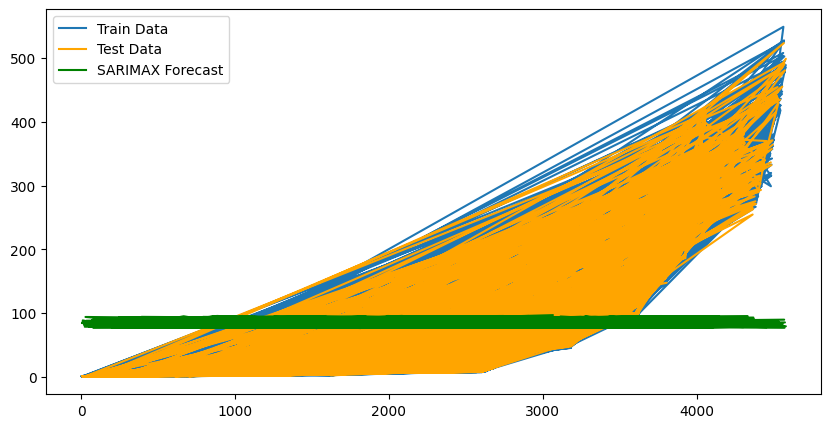

In [195]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# Stationarity Check
adf_test = adfuller(train_data)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# Define SARIMAX parameters
# (p, d, q): ARIMA terms
# (P, D, Q, s): Seasonal terms, where `s` is the seasonal period
p, d, q = (1, 1, 1)  # Example values; refine these based on ACF/PACF
P, D, Q, s = (1, 1, 1, 12)  # Example seasonal parameters; adjust `s` to your data's seasonality

# Fit SARIMAX model
sarimax_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarimax_result = sarimax_model.fit(disp=False)

# Model Summary
print(sarimax_result.summary())

# Forecasting
forecast_steps = len(test_data)
forecast = sarimax_result.forecast(steps=forecast_steps)

# Evaluate Model
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"RMSE: {rmse}")

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(train_data, label="Train Data")
plt.plot(test_data, label="Test Data", color="orange")
plt.plot(test_data.index, forecast, label="SARIMAX Forecast", color="green")
plt.legend()
plt.show()